<a href="https://colab.research.google.com/github/ehdgns21/CT-images-conversion-2D-3D/blob/main/dicom_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

处理医疗影像数据时，从医院拿到的一手数据，一般格式都是DICOM。所以认识和处理DICOM数据的步骤对于输入神经网络之前都是至关重要。用到库主要是pydicom和SimpleITK(Dicom先转换成NIFTI也是不错的选择~~~~~)

### DICOM简单介绍和简单处理

![](https://ai-studio-static-online.cdn.bcebos.com/a7c6928cf6b74994a80001388a0e05160c4a339e20074c279b2aec8c8bf4919c)

觉得DICOM格式文件。通俗一点来说，它有一部分是用来存储信息，例如病人名字，性别，检查号，检查部位，机器型号，像素间距等等。一部分就是存储图像，输入神经网络之前，一般都是把这图像部分转换成numpy进行处理。

用Pydicom库读取dicom文件，很轻易获取到患者的各种信息和图像数据



In [ ]:
#解压数据集
#数据来源https://www.ircad.fr/research/3d-ircadb-01/ 
#第一次运行要解压
%cd /home/aistudio/
!unzip data/data64579/LiverDicom.zip -d work

In [ ]:
#安装重要的库
#包括pydicom  和 SimpleITK 和 paddleseg这个神器
!pip install -r /home/aistudio/work/requirement.txt

患者名字：liver_18^patient
患者ID(已经去敏处理)）：
患者性别：M
患者检查ID：
图像行数：512
图像列数：512
切片厚度(mm)：2.5
图像像素间距(mm)：[0.742187976837158, 0.742187976837158]
窗位：0
窗宽：0
截取(转换CT值)：0
斜率(转换CT值)：1
其他信息：
<bound method Dataset.data_element of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 256
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.7328234484076085743939266417361578313
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.1.0.126.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 2.1.0'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/VTK 5.4.0'
-------------------------------------------------
(0008, 0008) Image Type                          C

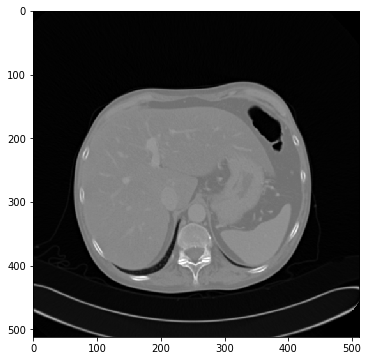

In [ ]:
#pydicom读取dicom数据
#没有图显示，再运行一次
import pydicom
import matplotlib.pyplot as plt
#读取单张dicom文件
df = pydicom.dcmread('/home/aistudio/work/LiverDicom/train/origin/18/image_48')
plt.figure(figsize=(6, 6))

#打印患者信息部分
print("患者名字：{}".format(df.PatientName))
print("患者ID(已经去敏处理)）：{}".format(df.PatientID))
print("患者性别：{}".format(df.PatientSex))
print("患者检查ID：{}".format(df.StudyID))
print("图像行数：{}".format(df.Rows))
print("图像列数：{}".format(df.Columns))
print("切片厚度(mm)：{}".format(df.SliceThickness))
print("图像像素间距(mm)：{}".format(df.PixelSpacing))
print("窗位：{}".format(df.WindowCenter))
print("窗宽：{}".format(df.WindowWidth))
print("截取(转换CT值)：{}".format(df.RescaleIntercept))
print("斜率(转换CT值)：{}".format(df.RescaleSlope))
print("其他信息：")
print(df.data_element)
#获取图像部分
img = df.pixel_array
plt.imshow(img, 'gray')
print("图像形状:{}".format(img.shape))
plt.show()

### 窗口技术

**从上面的单张图片预览情况来看。整个图像的对比度不高，组织之间差异之少。因为窗宽和窗位为0。只需要调整窗宽窗位即可。
窗口技术的描述可以看以下视频和解释(大佬不要喷。。)**

#### "不同窗宽窗位对CT图像显示的影像"



<iframe height="400" width="600" src="//player.bilibili.com/player.html?bvid=BV175411G7EB&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>

 **在拿到dicom图像后图像的像素一般是由CT(Hu)值组成，范围是-1024~3071，由于CT机是圆形孔径，生成的图像是矩形，其他地方会用一个很低负值(-2000或者-2048)来填充。但是图像也有可能是常见的灰度值组成。所以我觉得先读取dicom打印rescale intercept和rescale slope，看看是不是solpe=1，intercept=0，是就是由Hu组成。不是就要通过Hu = pixel * slope + intercept  进行转换成有Hu组成。**



#### 【窗口技术】窗口技术主要用来调节图像显示效果，以观察正常组织或病变组织为目的图像密度、对比度调节技术，包括窗宽和窗位

**在上面视频可以看到不同窗宽窗位，图像显示不一样。例如当窗宽350，窗位50左右的时候，肝脏、脾脏等软组织密度和对比度都比较合适。当窗宽1600，窗位600左右的时候，肋骨、椎体等骨质的组织的密度和对比度看起来比较合适。不同的组织的CT值可以当成一个固有属性。例如肝脏在50～ 70Hu，脾脏50～ 65Hu等。**

 **例如窗位选择50， 窗宽选择350，图像中可以显示的CT值范围就是（窗位-窗宽/2）至（窗位+窗宽/2）即-140~225，图像显示的时候只要CT值低于-140的组织都会显示黑色。CT值高于255都会显示白色。所以肝的CT值约50，要肝脏对比度显示的好，就先把窗位定在50，在选择窗宽。窗宽约大显示组织密度差别较大的结构，窗宽越窄，组织对比度强，显示密度差别较小的结构。**
 
 所以不同的窗宽窗位非常影响诊断医生的判断。例如右上角采用骨窗后对骨质是否有病变有一个很好的诊断。

![](https://ai-studio-static-online.cdn.bcebos.com/153a465663804ce0854e994e165a8181cb3bf28f43f94477925c132a43996b73)



### 对dicom数据进行CT值转换和窗宽窗位的调整

In [ ]:
#加载这个序列
import pydicom
import matplotlib.pyplot as plt
from numba import jit 
import numpy as np
import os
def load(path):
    #加载这个系列切片
    slices = [pydicom.read_file(os.path.join(path,s), force=True) for s in os.listdir(path)]
    #按z轴排序切片
    slices.sort(key= lambda x: float(x.ImagePositionPatient[2]))
    #计算切片厚度
    slice_thick = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    #同一厚度
    for s in slices:
        s.SliceThickness  = slice_thick
    return slices

#调整窗宽窗位之前把图像像素值变灰CT值
def get_pixel_hu(slices):
    #CT值和灰度值的转换公式 Hu = pixel * slope + intercept
    #三维数据 z,y,x排列
    images = np.stack([s.pixel_array  for s in slices])
    # 转换为int16
    images = images.astype(np.int16)
    # 设置边界外的元素为0
    images[images == -2048] = 0
    # 转换为HU单位
    for slice_num in range(len(slices)):
        #获取截取
        intercept = slices[slice_num].RescaleIntercept
        #获取斜率
        slope = slices[slice_num].RescaleSlope
        #有的图像就已经是CT值（HU值），这时候读出来的Solpe=1，Intercept=0。
        if slope != 1:
            images[slice_num] = slope * images[slice_num].astype(np.float64)
            images[slice_num] = images[slice_num].astype(np.int16)
        images[slice_num] = images[slice_num] + np.int16(intercept)
    return images


@jit(nopython=True)
def calc(img_temp, rows, cols, minval,maxval):
    for i in np.arange(rows):
        for j in np.arange(cols):
            #避免除以0的报错
            if maxval - minval == 0:
                result = 1
            else:
                result = maxval - minval
            img_temp[i, j] = int((img_temp[i, j] - minval) / result * 255)

# 调整CT图像的窗宽窗位
def setDicomWinWidthWinCenter(img_data,winwidth, wincenter):
    minval = (2*wincenter - winwidth) / 2.0 + 0.5
    maxval = (2*wincenter + winwidth) / 2.0 + 0.5
    for index in range(len(img_data)):
        img_temp = img_data[index]
        rows, cols = img_temp.shape
        # 采用numba加速计算
        calc(img_temp, rows, cols, minval, maxval)
        img_temp[img_temp < 0] = 0
        img_temp[img_temp > 255] = 255
        img_data[index] = img_temp
    return img_data


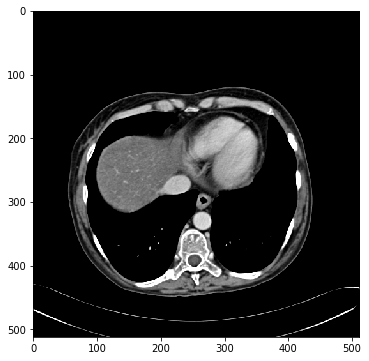

In [ ]:
#显示调整窗宽窗位，以看肝脏为目标
#设置窗宽窗位
winwidth = 350
wincenter = 50
#读取整个系列dicom文件
path = '/home/aistudio/work/LiverDicom/train/origin/18/'
patient = load(path)
#像素值转成CT值
patient_pixels = get_pixel_hu(patient)
#改变窗宽窗位
patient_pixels = setDicomWinWidthWinCenter(patient_pixels,winwidth,wincenter)
plt.figure(figsize=(6, 6))
plt.imshow(patient_pixels[65], 'gray')
plt.show()

## 这次使用的数据说明，大部分都是上腹部CT增强门脉期。

数据来源https://www.ircad.fr/research/3d-ircadb-01

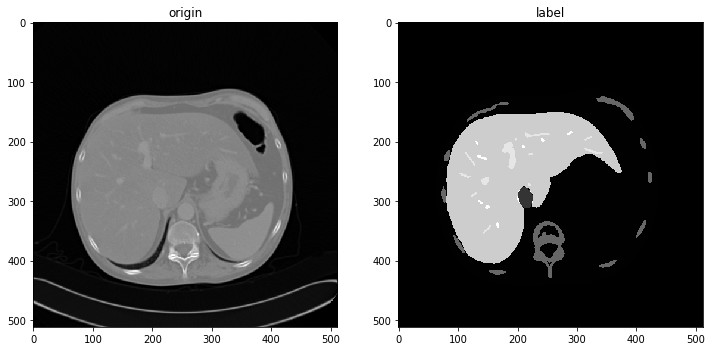

'\n看到label标签也是dicom格式，label数据里面看到的标签不单有肝脏，还有肝静脉，下腔静脉，门静脉，胆囊，皮肤，骨等等\n'

In [ ]:
#读取pydicom
import pydicom
import matplotlib.pyplot as plt
#读取单张dicom文件
df_origin = pydicom.dcmread('/home/aistudio/work/LiverDicom/train/origin/18/image_48')
df_label = pydicom.dcmread('/home/aistudio/work/LiverDicom/train/label/18/image_48')
plt.figure(figsize=(12, 6))

#获取图像部分
img_origin = df_origin.pixel_array
img_label = df_label.pixel_array
plt.subplot(121),plt.imshow(img_origin,'gray'), plt.title('origin')
plt.subplot(122),plt.imshow(img_label,'gray'),plt.title('label')
plt.show()

"""
看到label标签也是dicom格式，label数据里面看到的标签不单有肝脏，还有肝静脉，下腔静脉，门静脉，胆囊，皮肤，骨等等
"""

用ITK-SNAP软件查看label数据，可以看到肝脏、肝静脉、下腔静脉、肝门静脉的标签。从下图可以肝标签固定用了**129**数值，门静脉用了**145**数值，肝静脉用了**161**数值，下腔静脉用了**33**数值。根据这些数值就区分不同标签。不是全部label都是用相同的数值表示。所有要注意，不过肝静脉和肝门静脉的数值都包括这些：145,209,465,401,337,273,161,225,481,417,353,289。以下分割主要是针对肝静脉和肝门静脉。

![](https://ai-studio-static-online.cdn.bcebos.com/6c2c65e233234625bebe28267e32f575064db27967e34806b3c670b39bd11b6f)




### 开始处理label数据，编写DicomDataset

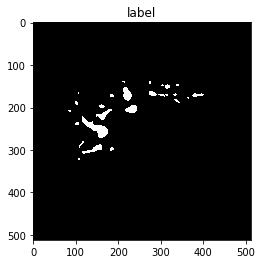

In [ ]:
"""
原label数据，格式是dicom，里面含有多种组织的数据，现在保留肝静脉和肝门静脉
"""
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from numba import jit

@jit(nopython=True)
def change_label_value(img_label):
    img_temp = np.zeros((512, 512), np.uint8)
    rows, cols = img_label.shape
    for i in np.arange(rows):
        for j in np.arange(cols):
            #肝门静脉和肝静脉在labelDicom里面的数值，不同的label数据数值不一样
            if img_label[i,j] in [145,209,465,401,337,273,161,225,481,417,353,289]:
                img_temp[i, j] = 255#为了展示，应该是1
    return img_temp

df_label = pydicom.dcmread('/home/aistudio/work/LiverDicom/train/label/8/image_80')
img_label = df_label.pixel_array
img_label = change_label_value(img_label)
img_label = Image.fromarray(np.int8(img_label))
plt.imshow(img_label),plt.title('label')
plt.show()

In [ ]:
"""
生成train.txt  val.txt，test.txt列表用于Dataset读取数据  ，顺便dicom转换成jpg格式。留着其他用途
"""
import os
from random import shuffle
import numpy as np
import pydicom
import cv2
from numba import jit

@jit(nopython=True)
def calc_label(img_label):
    img_temp = np.zeros((512, 512), np.uint8)
    rows, cols = img_label.shape
    for i in np.arange(rows):
        for j in np.arange(cols):
            if img_label[i,j] in [145,209,465,401,337,273,161,225,481,417,353,289]:
                img_temp[i, j] = 1
    return img_temp

cls = ['origin','label']
target_fold_origin = '/home/aistudio/work/Liverpng/train/origin/'
target_fold_label = '/home/aistudio/work/Liverpng/train/label/'
if not os.path.exists(target_fold_origin):
    os.makedirs(target_fold_origin)
if not os.path.exists(target_fold_label):
    os.makedirs(target_fold_label)
train_path = '/home/aistudio/work/LiverDicom/train/origin'
img_path_list = list()
index = 0
#train.txt
with open('/home/aistudio/work/LiverDicom/train.txt', 'w') as f:
    for folder in  os.listdir(train_path):
        for img in os.listdir(os.path.join(train_path,folder)):
            img_path = os.path.join(train_path,folder,img)
            df_origin = pydicom.dcmread(img_path)
            df_label = pydicom.dcmread(img_path.replace('origin','label'))
            img_label = df_label.pixel_array
            img_orgin = df_origin.pixel_array
            img_temp = calc_label(img_label)
            #去掉一些没有前景目标血管的切片
            if np.sum(img_temp) < 1:
                continue
            #这个把dicom图片保存jpg，可以用在paddleSeg开发套件中
            cv2.imwrite(target_fold_origin + str(index) + str(img) +'.jpg',img_orgin)
            cv2.imwrite(target_fold_label + str(index) + str(img) +'.png',img_temp)
            content = img_path  + '  ' + img_path.replace('origin','label') + '\n'
            img_path_list.append(content)
            index += 1
    # shuffle(img_path_list)
    img_path_list.sort()
    for path in img_path_list:
        f.write(path)
#val.txt
target_val_fold_origin = '/home/aistudio/work/Liverpng/val/origin/'
target_val_fold_label = '/home/aistudio/work/Liverpng/val/label/'
if not os.path.exists(target_val_fold_origin):
    os.makedirs(target_val_fold_origin)
if not os.path.exists(target_val_fold_label):
    os.makedirs(target_val_fold_label)
val_path = '/home/aistudio/work/LiverDicom/val/4/origin'
img_path_list = list()
index = 0
with open('/home/aistudio/work/LiverDicom/val.txt', 'w') as f:
    for img in os.listdir(val_path):
        img_path = os.path.join(val_path,img)
        df_origin = pydicom.dcmread(img_path)
        df_label = pydicom.dcmread(img_path.replace('origin','label'))
        img_label = df_label.pixel_array
        img_orgin = df_origin.pixel_array
        img_temp = calc_label(img_label)
        if np.sum(img_temp) < 1:
            continue
        #这个把dicom图片保存jpg，可以用在paddleSeg开发套件中
        cv2.imwrite(target_val_fold_origin + str(index) + str(img) +'.jpg',img_orgin)
        cv2.imwrite(target_val_fold_label + str(index) + str(img) +'.png',img_temp)
        content = img_path  + '  ' + img_path.replace('origin','label') + '\n'
        img_path_list.append(content)
        index += 1
    # shuffle(img_path_list)
    img_path_list.sort()
    for path in img_path_list:
        f.write(path)
#test.txt
target_test_fold_origin = '/home/aistudio/work/Liverpng/test/origin/'
target_test_fold_label = '/home/aistudio/work/Liverpng/test/label/'
if not os.path.exists(target_test_fold_origin):
    os.makedirs(target_test_fold_origin)
if not os.path.exists(target_test_fold_label):
    os.makedirs(target_test_fold_label)
test_path = '/home/aistudio/work/LiverDicom/test/10/origin'
img_path_list = list()
index = 0
with open('/home/aistudio/work/LiverDicom/test.txt', 'w') as f:
    for img in os.listdir(test_path):
        img_path = os.path.join(test_path,img)
        df_origin = pydicom.dcmread(img_path)
        df_label = pydicom.dcmread(img_path.replace('origin','label'))
        img_label = df_label.pixel_array
        img_orgin = df_origin.pixel_array
        img_temp = calc_label(img_label)
        # if np.sum(img_temp) < 1:
        #     continue
        cv2.imwrite(target_test_fold_origin + str(index) + str(img) +'.jpg',img_orgin)
        cv2.imwrite(target_test_fold_label + str(index) + str(img) +'.png',img_temp)
        content = img_path  + '  ' + img_path.replace('origin','label') + '\n'
        img_path_list.append(content)
        index += 1
    # shuffle(img_path_list)
    img_path_list.sort()
    for path in img_path_list:
        f.write(path)
print("完成")

完成


### 创建DataSet

In [ ]:
"""
创建DataSet

"""
from paddle.io import Dataset
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from numba import jit
from paddleseg.transforms import Compose
from paddle.vision.transforms import RandomHorizontalFlip,Resize,RandomVerticalFlip,RandomResizedCrop
from paddle.vision.transforms import CenterCrop,hflip,vflip,adjust_brightness,Normalize,ColorJitter
from paddle.vision.transforms.functional import rotate

@jit(nopython=True)
def _calc(img_temp,  minval,maxval):
    rows, cols = img_temp.shape
    for i in np.arange(rows):
        for j in np.arange(cols):
            #避免除以0的报错
            if maxval - minval == 0:
                result = 1
            else:
                result = maxval - minval
            img_temp[i, j] = int((img_temp[i, j] - minval) / result * 255)
    return img_temp

@jit(nopython=True)
def _calclabel(img_label):
    #根据label的dicom数据中，CT值不同，区分标签，并生成mask标签
    rows, cols = img_label.shape
    img_temp = np.zeros(img_label.shape, np.uint8)
    #这个img_mask可以不用管，暂时用不上
    img_mask = np.zeros(img_label.shape, np.uint8)
    for i in np.arange(rows):
        for j in np.arange(cols):
            if img_label[i,j] == 129:#肝脏
                img_mask[i, j] = 1
                # img_temp[i,j] = 2  #假如也把肝脏也分割，可以取消注释，那不再是二分类，
            elif img_label[i,j] in [145,209,465,401,337,273,161,225,481,417,353,289]:#静脉
                img_temp[i,j] = 1
                img_mask[i, j] = 1
    return (img_temp,img_mask)

class DicomDataset(Dataset):
    def __init__(self, mode='train',txt_file=None,transforms=None):
        super(DicomDataset, self).__init__()
        self.mode = mode.lower()
        self.txt_file = txt_file
        self.lines = []
        self.seed=2020
        self.transforms = transforms
        if self.mode == 'train':
            if self.txt_file is None:
                raise ValueError('train_txt cannot be empty ')
            self.lines = self.get_img_info(self.txt_file)
        elif self.mode == 'val':
            if self.txt_file is None:
                raise ValueError('val_txt cannot be empty ')
            self.lines = self.get_img_info(self.txt_file)        
        else:
            raise ValueError('mode must be "train" or "val"')

    def get_img_info(self, txt_file):
        #读取txt文档
        lines = list()
        with open(txt_file, 'r') as f:
            for line in f:
                imgA = line.split()[0].split()[0]
                imgB = line.split()[1].split()[0]
                lines.append((imgA, imgB))
        random.Random(self.seed).shuffle(lines)
        return lines

    def __getitem__(self, idx):
        # 加载原始图像
        imgA = self._load_img(self.lines[idx][0])
        imgB, imgBmask = self._change_label_value(self.lines[idx][1])
        imgA ,imgB = self.data_transform(imgA,imgB,imgBmask=None)
        return imgA, imgB

    def data_transform(self, imgA, imgB,imgBmask=None):
        imgA = np.array(imgA)
        imgB = np.array(imgB)

        imgA = np.expand_dims(imgA, axis=2)
        imgB = np.expand_dims(imgB, axis=2)

        h, w,_= imgA.shape
        imgA = imgA.astype('float32')
        imgA = cv2.cvtColor(imgA,cv2.COLOR_GRAY2BGR)
        if self.mode == 'train':
            if imgBmask is not None:
                imgBmask = np.array(imgBmask)
                imgBmask = np.expand_dims(imgBmask,axis=2)
                imgA = imgA * imgBmask
            if random.random() > 0.5:
                #随机旋转
                angle = random.randint(0,60)
                imgA = rotate(imgA, angle)
                imgB = rotate(imgB, angle)
            #随机水平翻转 和垂直翻转
            if random.random() > 0.5:
                imgA = hflip(imgA)
                imgB = hflip(imgB)
            if random.random() > 0.5:
                imgA = vflip(imgA)
                imgB = vflip(imgB)
            if len(imgB.shape) == 2:
                # imgA = np.expand_dims(imgA, axis=2)
                imgB = np.expand_dims(imgB, axis=2)
            if random.random() > 0.5:
                #随机调整图像的亮度，对比度，饱和度和色调
                val = round(random.random()/3,1)
                color = ColorJitter(val, val, val, val)
                imgA = imgA.astype('uint8')
                imgA = color(imgA)
                imgA = imgA.astype('float32')
            if random.random() > 0.2:
                #随机缩放
                resize = random.randint(512,650)
                resize = Resize(size=resize)
                imgA = resize(imgA)
                imgB = resize(imgB)
                centercrop = CenterCrop(512)
                imgA = centercrop(imgA)
                imgB = centercrop(imgB)
            if random.random() > 0.2:
                #随机生成4个小黑色方块遮挡
                for i in range(4):
                    black_width = 50
                    black_height = 50
                    width ,height,_ = imgA.shape
                    loc1 = random.randint(0,(width-black_width-1))
                    loc2 = random.randint(0,(height-black_width-1))
                    imgA[loc1:loc1+black_width,loc2:loc2+black_height:,:] = 0
                    imgB[loc1:loc1+black_width,loc2:loc2+black_height:,:] = 0

        imgA = imgA / 255. 
        # from [H,W] to [C,H,W]
        imgA = np.transpose(imgA, (2,0,1))
        imgB = np.transpose(imgB,(2,0,1))
        
        imgB = imgB.astype('int64')
        return (imgA,imgB)

    def _load_img(self, path):
        #处理origin数据（dicom格式）
        df_img = pydicom.dcmread(path)
        img = self.get_pixel_hu(df_img)
        #调整窗口窗位，以血管为中心
        # winwidth = random.randint(130,300)
        # wincenter = random.randint(30,99)
        # img = self.setDicomWinWidthWinCenter(img,winwidth,wincenter)
        img = self.setDicomWinWidthWinCenter(img,250,100)
        return img

    #调整窗宽窗位之前把图像像素值变灰CT值
    def get_pixel_hu(self,slices):
        #CT值和灰度值的转换公式 Hu = pixel * slope + intercept
        image = slices.pixel_array
        image = image.astype(np.float64)

        intercept = slices.RescaleIntercept
        slope = slices.RescaleSlope
        if slope != 1:
            image = slope * image
            image = image.astype(np.int16)
        image= image+ np.int16(intercept)
        return image

    def setDicomWinWidthWinCenter(self,img_data,winwidth, wincenter):
        # 调整CT图像的窗宽窗位
        minval = wincenter - winwidth/ 2.0
        maxval = wincenter + winwidth/2.0
        img_temp = img_data
        #加速计算
        img_temp = _calc(img_temp,minval, maxval)
        img_temp[img_temp < 0] = 0
        img_temp[img_temp > 255] = 255
        return img_temp

    def _change_label_value(self, label_path):
        #处理label（dicom格式）
        df_label = pydicom.dcmread(label_path)
        img_label = df_label.pixel_array
        #根据label的dicom数据中，CT值不同，区分标签，并生成mask标签
        img_temp , img_mask = _calclabel(img_label)
        return (img_temp,img_mask)

    def __len__(self):
        return len(self.lines)
        

=============train dataset=============
(3, 512, 512)
(1, 512, 512)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


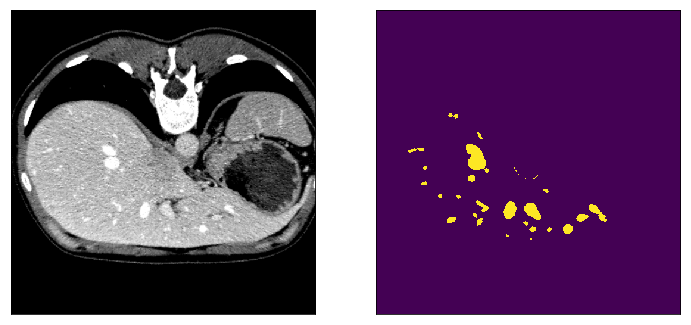

In [ ]:
# 测试定义的DataSet
from PIL import Image
import cv2
train_dataset = DicomDataset(mode='train',txt_file = '/home/aistudio/work/LiverDicom/train.txt')
print('=============train dataset=============')
imga, imgb = train_dataset[50]
print(imga.shape)
print(imgb.shape)
imga= (imga[0])*255
imga = Image.fromarray(np.int8(imga))
#当要保存的图片为灰度图像时，灰度图像的 numpy 尺度是 [1, h, w]。需要将 [1, h, w] 改变为 [h, w]
imgb = np.squeeze(imgb)

# imgb = Image.fromarray(np.int8(imgb))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1),plt.xticks([]),plt.yticks([]),plt.imshow(imga)
plt.subplot(1,2,2),plt.xticks([]),plt.yticks([]),plt.imshow(imgb)
plt.show()

###  使用Unet网络（直接使用paddleseg的动态版本， from paddleseg.models import UNet  使用啥网络就调用啥~~~~~）
 

In [ ]:
#也搭建了unet一下
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class MyUNet(nn.Layer):
    def __init__(self,num_classes=5,pretrained=None):
        super().__init__()
        self.encode = Encoder()
        self.decode = Decoder()
        self.cls = self.conv = nn.Conv2D(in_channels=64,out_channels=num_classes,kernel_size=3,padding=1)
        self.pretrained = pretrained

    def forward(self, x):
        logit_list = []
        x, short_cuts = self.encode(x)
        x = self.decode(x, short_cuts)
        logit = self.cls(x)
        logit_list.append(logit)
        return logit_list

class Encoder(nn.Layer):
    def __init__(self):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2D(in_channels=3,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2D(64),
            nn.Conv2D(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2D(64))
        down_channels = [[64, 128], [128, 256], [256, 512], [512, 512]]
        self.down_sample_list = nn.LayerList([
            self.down_sampling(channel[0], channel[1]) for channel in down_channels
        ])

    def down_sampling(self, in_channels, out_channels):
        layer = []
        layer.append(nn.MaxPool2D(kernel_size=2, stride=2))
        layer.append(nn.Conv2D(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1))
        layer.append(nn.BatchNorm2D(out_channels))
        layer.append(nn.Conv2D(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1))
        layer.append(nn.BatchNorm2D(out_channels))
        return nn.Sequential(*layer)

    def forward(self, x):
        short_cuts = []
        x = self.double_conv(x)
        for down_sample in self.down_sample_list:
            short_cuts.append(x)
            x = down_sample(x)
        return x, short_cuts

class Decoder(nn.Layer):
    def __init__(self):
        super().__init__()
        up_channels = [[512, 256], [256, 128], [128, 64], [64, 64]]
        self.up_sample_list = nn.LayerList([
            UpSampling(channel[0], channel[1])
            for channel in up_channels
        ])

    def forward(self, x, short_cuts):
        for i in range(len(short_cuts)):
            x = self.up_sample_list[i](x, short_cuts[-(i + 1)])
        return x

class UpSampling(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels):
        super().__init__()
        in_channels *= 2
        self.double_conv = nn.Sequential(
            nn.Conv2D(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2D(out_channels),
            nn.Conv2D(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2D(out_channels))

    def forward(self, x, short_cut):
        x = F.interpolate(x, short_cut.shape[2:], mode='bilinear')
        x = paddle.concat([x, short_cut], axis=1)
        x = self.double_conv(x)
        return x



In [ ]:
"""模型可视化"""
import numpy
import paddle
myunet = MyUNet(num_classes=5)
model = paddle.Model(myunet)
model.summary((3,3, 512, 512))

### 模型训练

In [ ]:
import paddle
import paddle.fluid as fluid
import numpy as np
from paddleseg.models import AttentionUNet,U2Netp,UNet,UNetPlusPlus

num_classes = 2
val_acc_history = []
val_loss_history = []
epoch_num = 300
#batch_size =4 效果比较好
batch_size = 4
#加载预训练模型 学习率采用0.0002以下
learning_rate = 0.0002

train_dataset = DicomDataset(mode='train',txt_file = '/home/aistudio/work/LiverDicom/train.txt')
val_dataset = DicomDataset(mode='val',txt_file = '/home/aistudio/work/LiverDicom/val.txt')

def create_loss(predict, label, num_classes=num_classes):
    ''' 创建loss，结合dice和交叉熵 '''
    predict = paddle.transpose(predict, perm=[0, 2, 3, 1])#shape[1, 512, 512, 2]
    predict = paddle.reshape(predict, shape=[-1, num_classes])#[num, 2]
    m = paddle.nn.Softmax()
    predict = m(predict)
    weight_data = paddle.uniform([0.1,0.9],dtype = "float32")
    weight = paddle.to_tensor(weight_data)
    ce_loss = paddle.nn.loss.CrossEntropyLoss(ignore_index=0,reduction='mean')
    #input 形状为 [N,C] , 其中 C 为类别数   label数据类型为int64。其形状为 [N] 
    ce_loss = ce_loss(predict, label) # 计算交叉熵
    dice_loss = fluid.layers.dice_loss(predict, label)  # 计算dice loss
    return fluid.layers.reduce_mean(dice_loss+ce_loss) # 最后使用的loss是dice和交叉熵的和

def focal_loss(predict, label, num_classes=num_classes):
    #使用focal loss 效果不怎么好
    label = paddle.cast(label, dtype='int32')
    predict = paddle.transpose(predict, perm=[0, 2, 3, 1])#shape[1, 512, 512, 2]
    predict = paddle.reshape(predict, shape=[-1, num_classes])#[num, 2]
    one = paddle.to_tensor([1.], dtype='int32')
    fg_label = paddle.greater_equal(label, one)
    fg_num = paddle.sum(paddle.cast(fg_label, dtype='int32'))
    loss = fluid.layers.sigmoid_focal_loss(x=predict,label=label,fg_num=fg_num,gamma=2.0,alpha=0.3)
    return paddle.mean(loss) 

def mean_iou(pred, label, num_classes=num_classes):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = paddle.argmax(pred, axis=1)
    label = np.squeeze(label, axis= 1)
    pred = paddle.cast(pred, 'int32')#转换数据类型
    label = paddle.cast(label, 'int32')
    miou, wrong, correct = paddle.metric.mean_iou(pred, label, num_classes)#计算均值IOU
    return miou

def train(model):
    print('开始训练 ... ')
    best_iou = 0.0
    model.train()
    # opt = paddle.optimizer.Momentum(learning_rate=learning_rate, parameters=model.parameters(), weight_decay=0.01)
    # scheduler = paddle.optimizer.lr.LambdaDecay(learning_rate=learning_rate, lr_lambda=lambda x:0.8**x, verbose=True)
    # scheduler = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=learning_rate, factor=0.5, patience=5, verbose=True)
    scheduler = paddle.optimizer.lr.PolynomialDecay(learning_rate=learning_rate, decay_steps=20, end_lr=0.00000125,cycle=True,verbose =True)
    opt = paddle.optimizer.Adam(learning_rate=scheduler,parameters=model.parameters())

    train_loader = paddle.io.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    valid_loader = paddle.io.DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = paddle.to_tensor(data[0], dtype='float32')
            y_data =  paddle.to_tensor(data[1], dtype='int64')#CrossEntropyLoss标签数据要int64格式   形状为 [N] 
            y_data = paddle.reshape(y_data, (-1, 1))

            output = model(x_data)
            acc = mean_iou(output[0], y_data)
            loss = create_loss(output[0], y_data,num_classes=num_classes)
            # loss = focal_loss(output[0], y_data,num_classes=num_classes)
            if batch_id % 20 == 0:
                print("epoch: {}, batch_id: {}, miou is :{} ,loss is: {}".format(epoch, batch_id, acc.numpy(),loss.numpy()))
            loss.backward()
            opt.minimize(loss)
            model.clear_gradients()
        scheduler.step()

        #训练期间验证
        model.eval()
        meaniou = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data = paddle.to_tensor(data[0], dtype='float32')
            y_data =  paddle.to_tensor(data[1], dtype='int64')
    
            output = model(x_data)
            acc = mean_iou(output[0], y_data)
            y_data = paddle.reshape(y_data, (-1, 1))
            loss = create_loss(output[0], y_data,num_classes=num_classes)
            # loss = focal_loss(output[0], y_data,num_classes=num_classes)
            
            meaniou.append(np.mean(acc.numpy()))
            losses.append(np.mean(loss.numpy()))
        avg_iou, avg_loss = np.mean(meaniou), np.mean(losses)
        print("[validation] miou/loss: {}/{}".format(avg_iou, avg_loss))
        val_acc_history.append(avg_iou)
        val_loss_history.append(avg_loss)
        model.train()
        if avg_iou > best_iou :
            best_iou = avg_iou
            paddle.save(model.state_dict(), "/home/aistudio/work/out/"+ "unet" +"_net.pdparams")
            print('成功保存模型')
        
model_path = '/home/aistudio/pretrained_model.pdparams'
# model = AttentionUNet(num_classes=num_classes)
model = UNet(num_classes=num_classes,  pretrained=model_path)
train(model)


In [ ]:
#验证验证集模型
import cv2
import numpy as np 
from paddleseg.models import UNet
def mean_iou(pred, label, num_classes):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = paddle.argmax(pred, axis=1)
    label = np.squeeze(label, axis= 1)
    pred = paddle.cast(pred, 'int32')#转换数据类型
    label = paddle.cast(label, 'int32')
    miou, wrong, correct = paddle.metric.mean_iou(pred, label, num_classes)#计算均值IOU
    return miou

val_dataset = DicomDataset(mode='val',txt_file = '/home/aistudio/work/LiverDicom/val.txt')
valid_loader = paddle.io.DataLoader(val_dataset, batch_size=4)

model = UNet(num_classes=2)
#这个我是训练的模型，注意修改
para_state_dict = paddle.load("/home/aistudio/work/out/unetaug_net.pdparams")
model.set_state_dict(para_state_dict)
model.eval()
meaniou = []
for batch_id, data in enumerate(valid_loader()):
    x_data = paddle.to_tensor(data[0], dtype='float32')
    y_data =  paddle.to_tensor(data[1], dtype='int64')
    output = model(x_data)
    acc = mean_iou(output[0], y_data, num_classes=2)
    y_data = paddle.reshape(y_data, (-1, 1))
    meaniou.append(np.mean(acc.numpy()))
avg_iou = np.mean(meaniou)
print("[validation] miou: {}".format(avg_iou))

[validation] miou: 0.7272036671638489


输入大小为：  [1, 3, 512, 512]


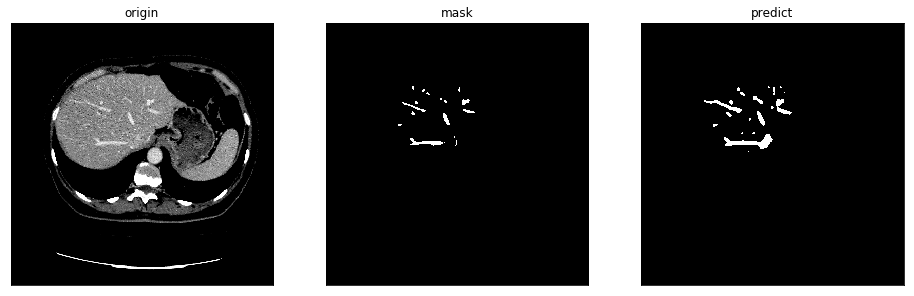

In [ ]:
#在测试集测试模型效果
import cv2
import numpy as np 
from paddleseg.models import UNet
val_dataset = DicomDataset(mode='val',txt_file = '/home/aistudio/work/LiverDicom/test.txt')
imga, imgb = val_dataset[91]
imgorigin  = imga.copy()
imga = np.expand_dims(imga, axis=0)

segmentation = np.zeros((512,512,1))
x_data = paddle.to_tensor(imga, dtype='float32')
print('输入大小为： ', x_data.shape)

model = UNet(num_classes=2)
#这个我是训练的模型，注意修改
para_state_dict = paddle.load("/home/aistudio/work/out/unetaug_net.pdparams")
model.set_state_dict(para_state_dict)

model.eval()
output = model(x_data)[0]
output = output.numpy()
output = np.argmax(output,axis=1)

output = output.transpose(1,2,0)
for i in np.arange(512):
    for j in np.arange(512):
        if output[i,j,0] == 1:
            output[i,j,0] = 255
cv2.imwrite('output.jpg', output)
segmentation[:, :, 0] = output[:,:,0] # 保存分割结果
plt.figure(figsize=(16, 6))
segmentation = np.squeeze(segmentation)
imgorigin = np.transpose(imgorigin,(1,2,0))
plt.subplot(1,3,1),plt.imshow(imgorigin,'gray'), plt.title('origin'),plt.xticks([]),plt.yticks([])
plt.subplot(1,3,2),plt.imshow(np.squeeze(imgb), 'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
plt.subplot(1,3,3),plt.imshow(segmentation, 'gray'),plt.title('predict'),plt.xticks([]),plt.yticks([])
plt.show()



### 开始分割肝脏

**血管分割效果不怎么好，现在分割整个肝脏，然后做MIP，肝脏的代码和上面分割血管的差不多**


In [ ]:
#第一次运行要解压
# %cd /home/aistudio/work/
!unzip /home/aistudio/data/data66280/OnlyLiver.zip -d /home/aistudio/work/

In [ ]:
#生成train.txt 和 val.txt和test.txt 文档
!python /home/aistudio/work/OnlyLiverTool/create_train_txt.py

完成


=============train dataset=============
(3, 512, 512)
(1, 512, 512)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


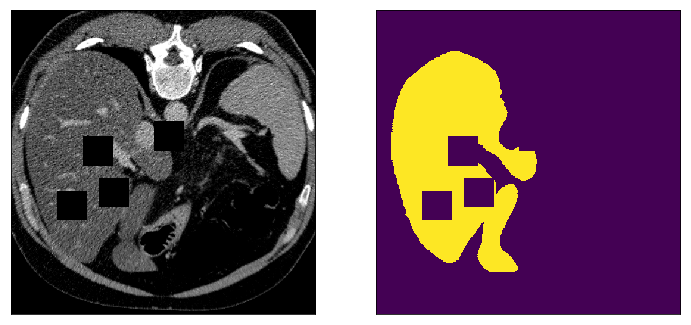

In [ ]:
import sys
sys.path.append('/home/aistudio/work/OnlyLiverTool')
from create_DataSet import DicomDataset
# 测试定义的DataSet
from PIL import Image
import cv2
import matplotlib.pyplot as plt
train_dataset = DicomDataset(mode='train',txt_file = '/home/aistudio/work/OnlyLiver/train.txt')
print('=============train dataset=============')
imga, imgb = train_dataset[30]
print(imga.shape)
print(imgb.shape)
imga= (imga[0])*255
imga = Image.fromarray(np.int8(imga))
#当要保存的图片为灰度图像时，灰度图像的 numpy 尺度是 [1, h, w]。需要将 [1, h, w] 改变为 [h, w]
imgb = np.squeeze(imgb)

# imgb = Image.fromarray(np.int8(imgb))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1),plt.xticks([]),plt.yticks([]),plt.imshow(imga)
plt.subplot(1,2,2),plt.xticks([]),plt.yticks([]),plt.imshow(imgb)
plt.show()

In [ ]:
#训练模型，分割肝脏
import sys
sys.path.append('/home/aistudio/work/OnlyLiverTool')
from train import train
from paddleseg.models import AttentionUNet,U2Netp,UNet,UNetPlusPlus
#预训练模型
model_path = '/home/aistudio/pretrained_model.pdparams'
model = UNet(num_classes=num_classes,  pretrained=model_path)
#模型保存名："/home/aistudio/work/out/"  +  model_net.pdparams 
train(model,"/home/aistudio/work/out/")

In [ ]:
#验证验证集模型
#得到验证集0.9599分
#测试集0.97199分
#这次分割肝脏效果还可以，用来做肝脏的MIP
import cv2
import numpy as np 
from paddleseg.models import UNet
import sys
sys.path.append('/home/aistudio/work/OnlyLiverTool')
from create_DataSet import DicomDataset
def mean_iou(pred, label, num_classes):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = paddle.argmax(pred, axis=1)
    label = np.squeeze(label, axis= 1)
    pred = paddle.cast(pred, 'int32')#转换数据类型
    label = paddle.cast(label, 'int32')
    miou, wrong, correct = paddle.metric.mean_iou(pred, label, num_classes)#计算均值IOU
    return miou

val_dataset = DicomDataset(mode='val',txt_file = '/home/aistudio/work/OnlyLiver/val.txt')
valid_loader = paddle.io.DataLoader(val_dataset, batch_size=4)

model = UNet(num_classes=2)
para_state_dict = paddle.load("/home/aistudio/work/out/liver_net.pdparams")
model.set_state_dict(para_state_dict)
model.eval()
meaniou = []
for batch_id, data in enumerate(valid_loader()):
    x_data = paddle.to_tensor(data[0], dtype='float32')
    y_data =  paddle.to_tensor(data[1], dtype='int64')
    output = model(x_data)
    acc = mean_iou(output[0], y_data, num_classes=2)
    y_data = paddle.reshape(y_data, (-1, 1))
    meaniou.append(np.mean(acc.numpy()))
avg_iou = np.mean(meaniou)
print("[validation] miou: {}".format(avg_iou))

[validation] miou: 0.9599464535713196


输入大小为：  [1, 3, 512, 512]


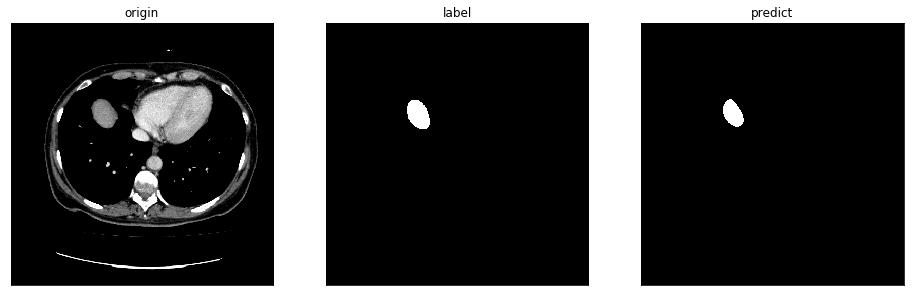

输入大小为：  [1, 3, 512, 512]


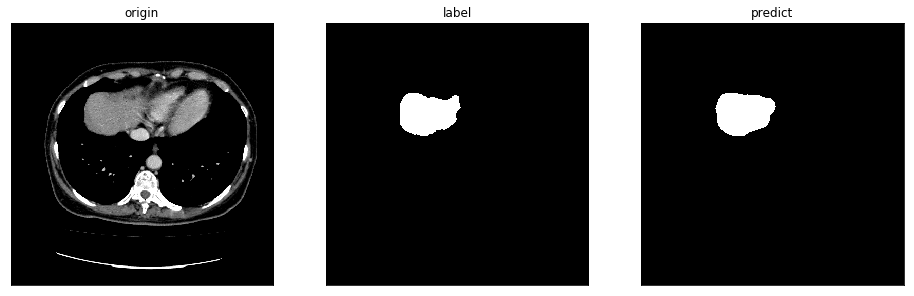

输入大小为：  [1, 3, 512, 512]


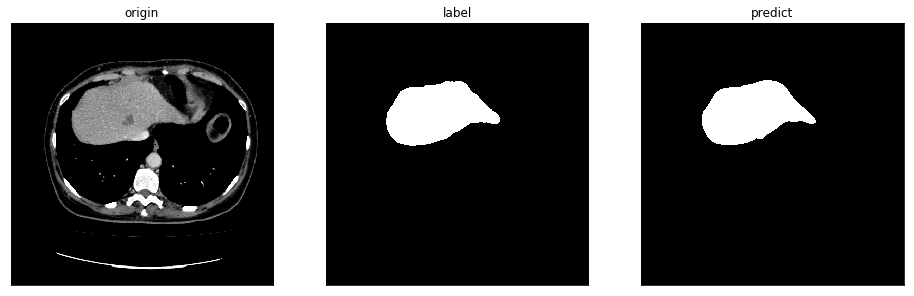

输入大小为：  [1, 3, 512, 512]


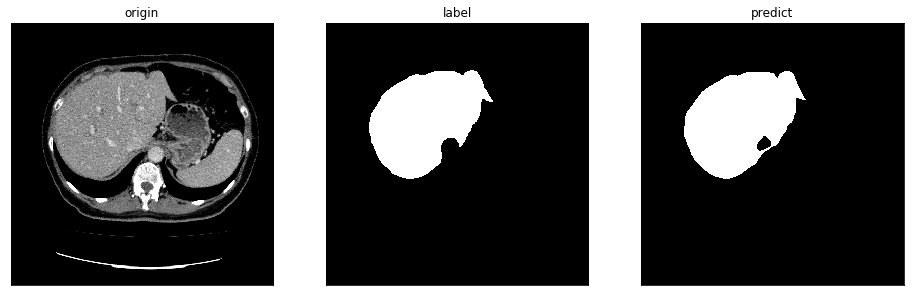

输入大小为：  [1, 3, 512, 512]


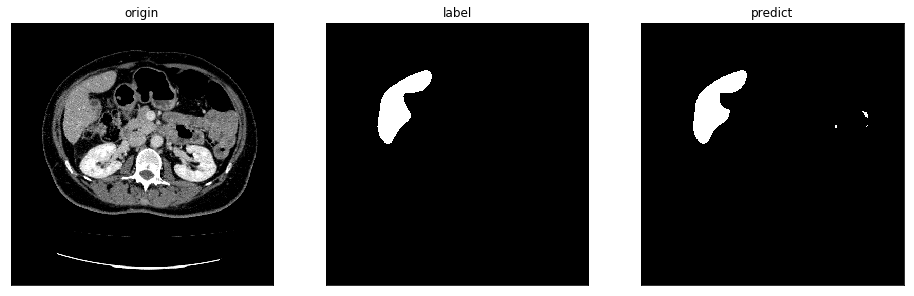

In [ ]:
#在测试集测试模型效果
import cv2
import numpy as np 
from paddleseg.models import UNet
import sys
import paddle
import matplotlib.pyplot  as plt
sys.path.append('/home/aistudio/work/OnlyLiverTool')
from create_DataSet import DicomDataset
val_dataset = DicomDataset(mode='val',txt_file = '/home/aistudio/work/OnlyLiver/test.txt')
for i in range(9,14):
    imga, imgb = val_dataset[i]
    imgorigin  = imga.copy()
    imga = np.expand_dims(imga, axis=0)

    segmentation = np.zeros((512,512,1))
    x_data = paddle.to_tensor(imga, dtype='float32')
    print('输入大小为： ', x_data.shape)

    model = UNet(num_classes=2)
    para_state_dict = paddle.load("/home/aistudio/work/out/liver_net.pdparams")
    model.set_state_dict(para_state_dict)

    model.eval()
    output = model(x_data)[0]
    output = output.numpy()
    output = np.argmax(output,axis=1)

    output = output.transpose(1,2,0)
    for i in np.arange(512):
        for j in np.arange(512):
            if output[i,j,0] == 1:
                output[i,j,0] = 255
    segmentation[:, :, 0] = output[:,:,0] # 保存分割结果
    plt.figure(figsize=(16, 6))
    segmentation = np.squeeze(segmentation)
    imgorigin = np.transpose(imgorigin,(1,2,0))
    plt.subplot(1,3,1),plt.imshow(imgorigin,'gray'), plt.title('origin'),plt.xticks([]),plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(np.squeeze(imgb), 'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(segmentation, 'gray'),plt.title('predict'),plt.xticks([]),plt.yticks([])
    plt.show()

(122, 512, 512)
(0.736000001430511, 0.736000001430511, 1.6000000238418595)
重采样后
(265, 512, 512)
(0.736000001430511, 0.736000001430511, 0.736000001430511)


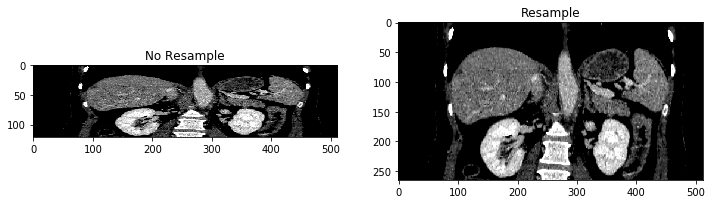

In [ ]:
#对test的dicom数据进行重采样，改变层距不然展示图片的时候会有变形
#但是觉得这样重采样层数变多后。效果还是没有直接CT机处理后的薄层volume数据号看，感觉好多噪声。可能重采样用的插值不一样？

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from PIL import Image

def resample(images):
    resample = sitk.ResampleImageFilter()# 创建一个重采样器
    resample.SetInterpolator(sitk.sitkLinear)# 设置插值方式
    resample.SetOutputOrigin(images.GetOrigin())# 设置原点
    resample.SetOutputDirection(images.GetDirection())# 设置方向
    # 设置像素间距
    newspacing = [images.GetSpacing()[0], images.GetSpacing()[0], images.GetSpacing()[0]]
    outsize = [0, 0, 0]
    # 计算方法，原形象乘以原像素间距，再乘以新的像素间距，就可以得到新的形象
    outsize[0] = int(images.GetSize()[0] * images.GetSpacing()[0] / newspacing[0] + 0.5)
    outsize[1] = int(images.GetSize()[1] * images.GetSpacing()[1] / newspacing[1] + 0.5)
    outsize[2] = int(images.GetSize()[2] * images.GetSpacing()[2] / newspacing[2] + 0.5)
    # 设置输出形状
    resample.SetSize(outsize)
    resample.SetOutputSpacing(newspacing)
    # 生成新数据
    new_images = resample.Execute(images)
    return new_images

#读取dicom序列
path = '/home/aistudio/work/LiverDicom/test/10/origin'
reader = sitk.ImageSeriesReader()
dicom_name = reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dicom_name)
images = reader.Execute()
image_array = sitk.GetArrayFromImage(images)
#旋转角度
no_resample_image = np.transpose(image_array[:,250,:], (1,0))
no_resample_image  = Image.fromarray(no_resample_image)
no_resample_image = no_resample_image.rotate(90,expand=True)

print(image_array.shape) #SimpleITK读取的图像数据的坐标顺序为zyx
print(images.GetSpacing())#xyz
print("重采样后")
new_images = resample(images)
images_array = sitk.GetArrayFromImage(new_images)
#旋转角度
resample_image = np.transpose(images_array[:,250,:], (1,0)) 
resample_image  = Image.fromarray(resample_image)
resample_image = resample_image.rotate(90,expand=True)
#逆时针选择90度
print(images_array.shape) #zyx
print(new_images.GetSpacing())#xyz
plt.figure(figsize=(12,6))
plt.subplot(121),plt.imshow(no_resample_image,'gray'),plt.title('No Resample')
plt.subplot(122),plt.imshow(resample_image,'gray'),plt.title('Resample')
plt.show()

#保存重采样后的数据为nii
sitk.WriteImage(new_images,'/home/aistudio/work/resampleTest.nii.gz')

In [ ]:
#读取新保存后重采样的nii文件，并开始预测
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from paddleseg.models import UNet
import paddle
from numba import jit
import cv2
@jit(nopython=True)
def calc(img_temp,  minval,maxval):
    rows, cols = img_temp.shape
    for i in np.arange(rows):
        for j in np.arange(cols):
            #避免除以0的报错
            if maxval - minval == 0:
                result = 1
            else:
                result = maxval - minval
            img_temp[i, j] = int((img_temp[i, j] - minval) / result * 255)
    return img_temp
#加载模型
model = UNet(num_classes=2)
para_state_dict = paddle.load("/home/aistudio/work/out/liver_net.pdparams")
model.set_state_dict(para_state_dict)
model.eval()
#加载nii文件
vols = sitk.ReadImage('/home/aistudio/work/resampleTest.nii.gz')
images = sitk.GetArrayFromImage(vols)

images = np.transpose(images,(2,1,0))
rows, cols, dims = images.shape
segmentation = np.zeros((rows,cols,dims))
#设置和训练时候一直的窗宽窗位。
winwidth = 350
wincenter = 80
minval = wincenter - winwidth/ 2.0
maxval = wincenter + winwidth/2.0
for dim in range(dims):
    image = images[:,:,dim].T
    image_temp = image
    image = calc(image,minval, maxval)
    image[image < 0] = 0
    image[image > 255] = 255
    
    image = image /255.0
    image = np.expand_dims(image, axis=2)#WxH  to  WxHxC
    image = np.concatenate([image] * 3, axis=2) #变成三通道
    image = np.transpose(image,(2,0,1))#WxHxC to  CxWxH
    x_data = np.expand_dims(image, axis=0)#CxWxH to  BxCxWxH
    x_data = paddle.to_tensor(x_data, dtype='float32')
    output = model(x_data)[0]
    output = output.numpy()
    output = np.argmax(output,axis=1)
    output = output.transpose(1,2,0) #WxHxC

    #对预测出来的标签进行闭运算，填补里面的小黑洞
    output = output.astype(np.uint8)
    output = np.squeeze(output)
    kernel = np.ones((50,50), np.uint8)
    output = cv2.morphologyEx(output,cv2.MORPH_CLOSE,kernel)
    output = np.expand_dims(output, axis=2)

    # output[output == 1] = 255
    image_temp = np.expand_dims(image_temp, axis=2)#WxH  to  WxHxC
    result = image_temp * output
    # plt.figure(figsize=(18,6))
    # plt.subplot(131),plt.imshow(np.squeeze(output),'gray')
    # plt.subplot(132),plt.imshow(np.squeeze(image_temp),'gray')
    # plt.subplot(133),plt.imshow(np.squeeze(result),'gray')
    # plt.show()
    segmentation[:, :, dim] = result[:,:,0] # 保存分割结果
segmentation = np.transpose(segmentation, (2,0,1))
out = sitk.GetImageFromArray(segmentation)
out.SetSpacing(vols.GetSpacing())
out.SetOrigin(vols.GetOrigin())
sitk.WriteImage(out,'/home/aistudio/work/segmentation.nii.gz')
print("完成")

完成


### MIP（最大密度投影）
MIP是CT对增强扫描后处理的一种常见的方法。

设想有许多投影线，取每条投影线经过的所有体素中最大的一个体素值，作为投影图像中对应的像素值，由所有投影线对应的若干个最大密度的像素所组成的图像即为最大密度投影所产生的图像。常用于显示密度相对较高的组织结构，如注射对比剂后显影的血管和明显强化的肿块等，该技术的优势是可以较真实地反映组织的密度差异,清楚地显示造影剂强化的血管形态、走向、异常改变及血管壁钙化和分布的情况。

再MIP之前，一般先经过工作站，人工去掉高密度的骨质部分，只保留软组织和血管部分。
在这里通过把肝脏分割出来，只保留了肝脏。然后再进行MIP处理。避免其他脏器和骨质的遮挡。从而可以观察肝静脉和肝门静脉的全貌。

<iframe height="400" width="600" src="//player.bilibili.com/player.html?bvid=BV1yA411p7gk&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


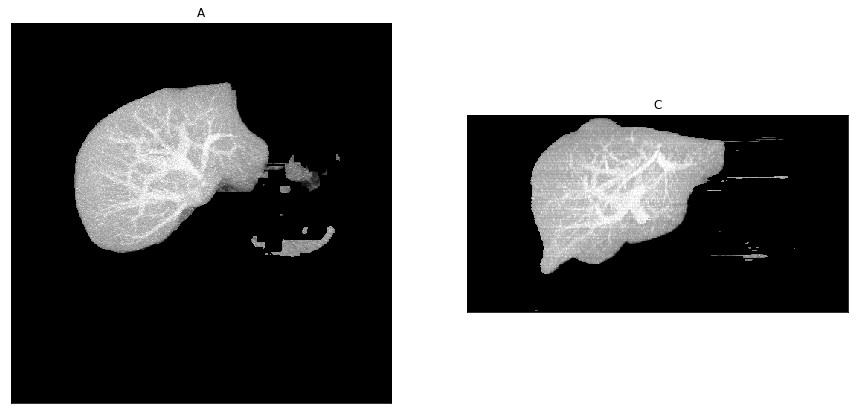

In [ ]:
#读取预测保存后的nii文件进行MIP处理
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import cv2

# @jit(nopython=True)
def calc_MIP(temp,axis=None):
    rows, cols, dims = images.shape
    if axis == 'C':#冠状位
        img_mip = np.zeros((rows, dims))
        for i in range(rows):
            for j in range(dims):
                value = np.max(temp[i,:,j])
                img_mip[i, j] = value
        img_mip = np.rot90(img_mip)
    elif axis == 'A':#横断位
        img_mip = np.zeros((rows, cols))
        for i in range(rows):
            for j in range(cols):
                value = np.max(temp[i,j,:])
                img_mip[i, j] = value
        img_mip = cv2.flip(img_mip, 1)
        img_mip = np.rot90(img_mip)
    return img_mip

def setWin(image, winwidth, wincenter):
    minval = wincenter - winwidth/ 2.0
    maxval = wincenter + winwidth/2.0
    image = (image - minval)/(maxval - minval) * 255
    image[image < 0] = 0
    image[image > 255] = 255
    return image

#加载nii文件
vols = sitk.ReadImage('/home/aistudio/work/segmentation.nii.gz')
images = sitk.GetArrayFromImage(vols)
images = np.transpose(images,(2,1,0))
# images = images[:,80:300,:]

result_A = calc_MIP(images,axis='A')
result_A = setWin(result_A, 200,140)
result_C = calc_MIP(images,axis='C')
result_C = setWin(result_C, 200,140)

plt.figure(figsize=(15,7))
plt.subplot(121),plt.imshow(result_A, 'gray'),plt.title("A"),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(result_C, 'gray'),plt.title("C"),plt.xticks([]),plt.yticks([])
plt.show()

本应该分割骨头，根据预测结果，去掉骨头保留血管和软组织，做MIP效果才好，不是单纯做肝脏。这样不能全面观察器官的关系。
[这个数据集标签是骨头，有兴趣的可以分割骨头，再做MIP](https://aistudio.baidu.com/aistudio/datasetdetail/66353)~~~

### 总结
**首先想说觉得paddle的开发工具越来越亲民了。特别这次用了动态版的PaddleSeg，像一个库那样Import。结果paddle2.0真的很方便。只要处理好数据的部分。其他都是模板式套用。**

**在这次分割血管的任务中，miou只有72左右，不是很理想。如果有大佬可以做到90以上。请告知！！**

**后来再分割了肝脏。在测试集上有miou97,做了MIP效果还不错。**

**为什么要做这个基础项目，一方面和自己专业相关。一方面想让更多医学出身的。特别是在放射科工作的医生和技师。在接触人工智能，把门槛放得更低。经常看到有人问，哪里有CT的公开的数据，那里有MR的数据，怎样和放射科合作等等。而作为放射科医生明明身边有各种各样的医学影像数据。为什么不自己去做。自己不单只可以做数据标签，又可以自己训练，这不是一举两得吗？自己不是更加了解什么功能的人工智能更加适合临床吗？这也是为医学贡献和发展的一条道路。**

### 个人介绍

广州某医院的放射科的一名放射技师。

只是一位编程爱好者

只是想把自己的爱好融入工作中

只是想让自己通过努力获取成就和快乐

欢迎更多志同道合的朋友一起玩耍~~~

我在AI Studio上获得黄金等级，点亮5个徽章，来互关呀~ [主页](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/181096)